<a href="https://colab.research.google.com/github/Soulfex/Deep_Learning/blob/main/4_Red_completamente_conectada_con_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Red completamente conectada con PyTorch

Implementa una red completamente conectada para la tarea de clasificación de imágenes sobre el conjunto de Fashion-MNIST, tomando en cuenta las siguiente especificaciones:

- Explora con diferentes número de neuronas, capas, funciones de activación e hiperparámetros.
-Discute tus resultados con las distintas configuraciones.

In [21]:
# Importamos librerias 

# números aleatorios
import random

import math
# sistema de archivos
import os

# redes neuronales
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optimizer
import torch.optim as optim
import torch.nn.functional as F

# tomar n elementos de una secuencia
from itertools import islice as take

import torchvision
import torchvision.datasets.utils as tutils
import torchvision.datasets as DataSets
from torchvision.datasets import FashionMNIST
from torchvision import transforms
# imágenes
from skimage import io
# arreglos multidimensionales
import numpy as np
# inspección de arquitectura
from torchsummary import summary
# barras de progreso

from tqdm.auto import trange
# gráficas
from matplotlib import pyplot as plt

In [22]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"

device = torch.device(dev)
print(device)

cuda:0


Fashion-MNIST es un conjunto de datos de imágenes de artículos de Zalando que consta de un conjunto de entrenamiento de 60 000 ejemplos y un conjunto de prueba de 10 000 ejemplos. Cada ejemplo es una imagen en escala de grises de 28x28, asociada con una etiqueta de 10 clases.

## Cargamos los datos

In [23]:
# directorio de datos
DATA_DIR = './data/FashionMNIST'



# tamaño del lote
BATCH_SIZE = 32

# reproducibilidad
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [24]:
# Use standard FashionMNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = np.array)

label = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

# Media y desviación estandar para  normalizar los datos para una convergencia más rápida

MEAN = train_dataset.train_data.float().mean()/255.0
MEAN = (MEAN.item(),)
STD = train_dataset.train_data.float().std()/255.0
STD = (STD.item(),)


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [25]:
def display_grid(xs, titles, rows, cols):

    fig, ax = plt.subplots(rows, cols, figsize = (15,10))
    for r in range(rows):
        for c in range(cols):
            i = r * rows + c
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
    fig.tight_layout()
    plt.show()

### Exploración

images[0] shape=(28, 28) dtype=uint8


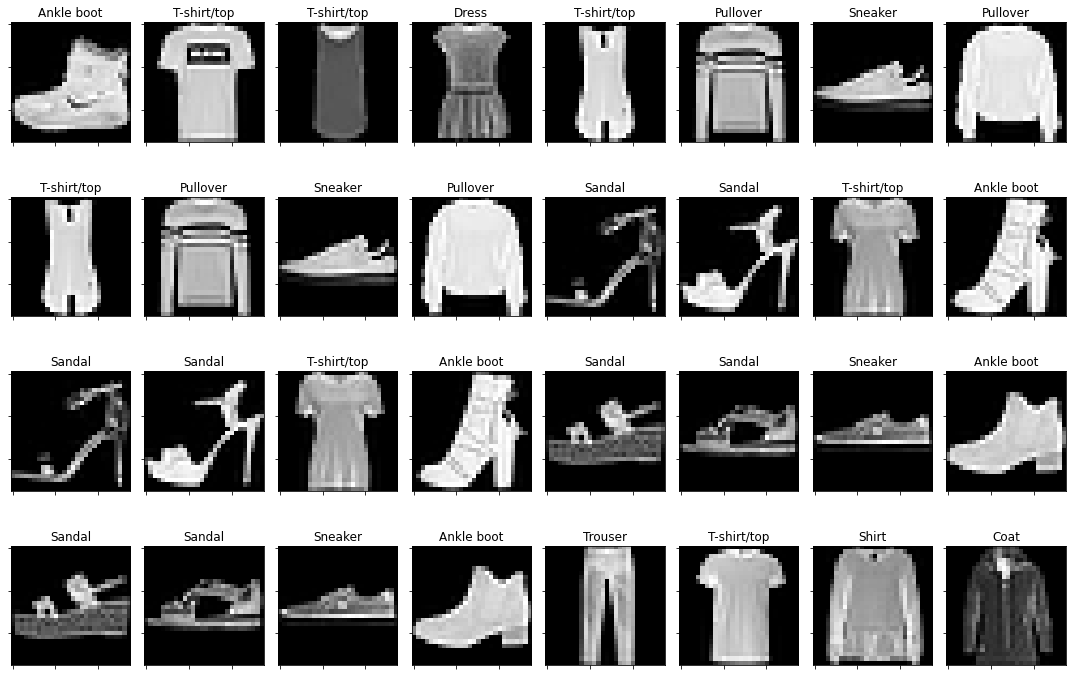

In [26]:
# cargamos algunas imágenes
images, labels = [], []
for i in range(BATCH_SIZE):
    x, y = train_dataset[i]
    images.append(x)
    labels.append(label[y])

# desplegamos
print(f'images[0] shape={images[0].shape} dtype={images[0].dtype}')
titles = [str(y) for y in labels]
display_grid(images, titles, 4, 8)

## Cargadores de datos

#### Entrenamiento


In [27]:
# transformaciones para la imagen
trn_tsfm = transforms.Compose([
    # convertimos a torch.Tensor y escalamos a [0,1]
    transforms.ToTensor(),
    # estandarizamos: restamos la media y dividimos sobre la varianza
    transforms.Normalize(MEAN, STD),
])

# creamos un Dataset
trn_ds = FashionMNIST(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # transformación
    transform= trn_tsfm
)

# creamos un DataLoader
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)


x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([32, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


#### Prueba

In [28]:
# creamos un Dataset
tst_ds = FashionMNIST(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=False,
    # transformación
    transform=trn_tsfm
)

# creamos un DataLoader
tst_dl = DataLoader(
    # subconjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(tst_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')


x shape=torch.Size([32, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


### Explora con diferentes número de neuronas, capas, funciones de activación e hiperparámetros.

Con una capa oculta de 128 neuronas, usando función de activación ReLU

In [29]:
# definición del modelo
class FCN_1(nn.Module):

    # definimos el constructor que recibe los parámetros que vamos a variar
    def __init__(self):
        # inicilización del objeto padre, obligatorio
        super(FCN_1, self).__init__()

        # tamaño de la entrada
        self.I = 1 * 28 * 28
        # tamaño de la salida 
        

        FC1, FC2 = 128, 10

      #definimos las capas
        self.cls = nn.Sequential(
            #primer fully conected toma n vectores de 1x28x28 y transformalos a n vectores de 128
            nn.Linear(self.I, FC1),
            #funcion de activacion relu
            nn.ReLU(),
            # segunda fully conected entrada de 128 y salida de 10 (clases)
            nn.Linear(FC1, FC2)
        )
            
    #inferencia
    def forward(self, x):
        # [1,28,28]  => (1*28*28)
        x = x.view(-1, self.I)
        #inferencia
        x = self.cls(x)
        return x    

In [30]:
model_1 = FCN_1()
print(model_1)

FCN_1(
  (cls): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [31]:
# inferencia con datos sinteticos
x = torch.zeros(1, 1, 28, 28)
y = model_1(x)
print(y.shape)

torch.Size([1, 10])


### Entrenamiento

In [64]:
# Vamos a definir una función de entrenamiento que debe recibir los parámetros que vamos a variar

def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        for x, y_true in take(dl, num_batches):

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc

def train(model, trn_dl, tst_dl, lr , epochs,
          trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        for x, y_true in trn_dl:

          # computamos los logits
          y_lgts = model(x)

          # computamos la perdida

          loss = F.cross_entropy(y_lgts, y_true)
          # vaciamos los gradientes
          opt.zero_grad()

          # retropropagamos

          loss.backward()

          # actualizamos parámetros

          opt.step()


        # evaluamos la época en entrenamiento


        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist

def plot_loss_acc(loss, acc, param):


  fig,axes=plt.subplots(ncols=2, figsize = (18, 5))

  trn_loss, tst_loss = zip(*loss)
  sc1 = axes[0].plot(trn_loss, 'tab:orange', label='trn loss')
  sc12 = axes[0].plot(tst_loss, 'tab:red', label='tst loss')



  trn_acc, tst_acc = zip(*acc)
  sc2 = axes[1].plot(trn_acc, 'tab:green', label='trn acc')
  sc22 = axes[1].plot(tst_acc, 'tab:blue', label='tst acc')

  axes[0].set(xlabel='época', ylabel="pérdida")
  axes[1].set(xlabel='época', ylabel= "pérdida")
  axes[0].legend(loc="upper right")
  axes[1].legend(loc="upper right")

  axes[0].set_title('Entrenamiento:'+ param  , fontsize = 15)
  axes[1].set_title('Validacion:'+ param,   fontsize = 15)


  plt.show()

  
  


In [33]:
# Con tasa de aprendizaje de 0.005 y entrenando durante 40 epocas utilizando una función de activación ReLU
model = FCN_1()
loss, acc = train(model, trn_dl, tst_dl, 0.005, 40)

  0%|          | 0/40 [00:00<?, ?it/s]

E00 loss=[ 51.56, 54.03] acc=[82.06,80.91]
E01 loss=[ 45.09, 48.20] acc=[84.07,82.72]
E02 loss=[ 42.09, 45.66] acc=[85.25,83.83]
E03 loss=[ 40.13, 43.93] acc=[85.77,84.27]
E04 loss=[ 38.43, 42.59] acc=[86.34,84.77]
E05 loss=[ 37.52, 42.08] acc=[86.73,84.97]
E06 loss=[ 36.13, 40.87] acc=[87.15,85.38]
E07 loss=[ 35.22, 40.33] acc=[87.49,85.70]
E08 loss=[ 34.26, 39.57] acc=[87.85,85.73]
E09 loss=[ 33.25, 38.74] acc=[88.24,86.13]
E10 loss=[ 33.00, 38.70] acc=[88.25,86.07]
E11 loss=[ 32.34, 38.08] acc=[88.41,86.26]
E12 loss=[ 31.35, 37.32] acc=[88.91,86.58]
E13 loss=[ 30.73, 36.98] acc=[89.21,86.67]
E14 loss=[ 30.41, 36.78] acc=[89.19,86.71]
E15 loss=[ 30.00, 36.84] acc=[89.31,86.90]
E16 loss=[ 29.78, 36.81] acc=[89.48,87.09]
E17 loss=[ 29.26, 36.27] acc=[89.58,86.96]
E18 loss=[ 28.97, 36.21] acc=[89.62,87.04]
E19 loss=[ 28.06, 35.54] acc=[90.10,87.16]
E20 loss=[ 27.75, 35.22] acc=[90.12,87.30]
E21 loss=[ 27.43, 35.43] acc=[90.26,87.42]
E22 loss=[ 26.82, 34.64] acc=[90.59,87.44]
E23 loss=[ 

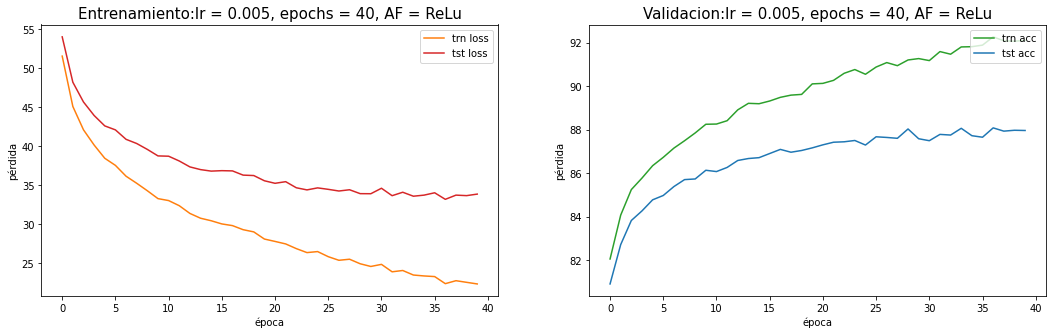

In [65]:
param = "lr = 0.005, epochs = 40, AF = ReLu"
plot_loss_acc(loss, acc,  param)

In [67]:
# Evaluación final

# evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch(trn_dl, model)
# evaluamos en prueba
tst_loss, tst_acc = eval_epoch(tst_dl, model)
print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[ 22.29, 33.89] acc=[92.10,87.94]


Exploremos que es lo que ocurre cuando usamos una función de activación sigmoide

In [62]:
# definición del modelo
class FCN_12(nn.Module):

    # definimos el constructor que recibe los parámetros que vamos a variar
    def __init__(self):
        # inicilización del objeto padre, obligatorio
        super(FCN_12, self).__init__()

        # tamaño de la entrada
        self.I = 1 * 28 * 28
        # tamaño de la salida 
        

        FC1, FC2 = 128, 10

      #definimos las capas
        self.cls = nn.Sequential(
            #primer fully conected toma n vectores de 1x28x28 y transformalos a n vectores de 128
            nn.Linear(self.I, FC1),
            #funcion de activacion relu
            nn.Sigmoid(),
            # segunda fully conected entrada de 128 y salida de 10 (clases)
            nn.Linear(FC1, FC2)
        )
            
    #inferencia
    def forward(self, x):
        # [1,28,28]  => (1*28*28)
        x = x.view(-1, self.I)
        #inferencia
        x = self.cls(x)
        return x    

In [63]:
# Con tasa de aprendizaje de 0.005 y entrenando durante 40 epocas usando una función de activación sigmoide
model12 = FCN_12()
loss12, acc12 = train(model12, trn_dl, tst_dl, 0.005, 40)

  0%|          | 0/40 [00:00<?, ?it/s]

E00 loss=[ 89.79, 90.71] acc=[73.55,72.78]
E01 loss=[ 69.31, 70.78] acc=[76.44,75.72]
E02 loss=[ 61.24, 63.02] acc=[78.78,77.76]
E03 loss=[ 56.43, 58.45] acc=[80.42,79.28]
E04 loss=[ 53.22, 55.46] acc=[81.50,80.28]
E05 loss=[ 50.85, 53.38] acc=[82.22,80.87]
E06 loss=[ 49.12, 51.78] acc=[82.78,81.30]
E07 loss=[ 47.66, 50.40] acc=[83.31,81.78]
E08 loss=[ 46.40, 49.36] acc=[83.74,82.30]
E09 loss=[ 45.48, 48.56] acc=[83.98,82.45]
E10 loss=[ 44.53, 47.69] acc=[84.34,82.83]
E11 loss=[ 43.77, 47.05] acc=[84.62,83.05]
E12 loss=[ 43.15, 46.56] acc=[84.87,83.27]
E13 loss=[ 42.40, 45.83] acc=[85.11,83.44]
E14 loss=[ 41.85, 45.33] acc=[85.20,83.66]
E15 loss=[ 41.31, 44.85] acc=[85.36,83.82]
E16 loss=[ 40.96, 44.70] acc=[85.54,83.88]
E17 loss=[ 40.40, 44.13] acc=[85.73,84.07]
E18 loss=[ 39.93, 43.68] acc=[85.92,84.29]
E19 loss=[ 39.66, 43.49] acc=[85.97,84.30]
E20 loss=[ 39.28, 43.21] acc=[86.09,84.56]
E21 loss=[ 38.89, 42.85] acc=[86.34,84.51]
E22 loss=[ 38.50, 42.49] acc=[86.42,84.63]
E23 loss=[ 

In [79]:
print(model12)

FCN_12(
  (cls): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


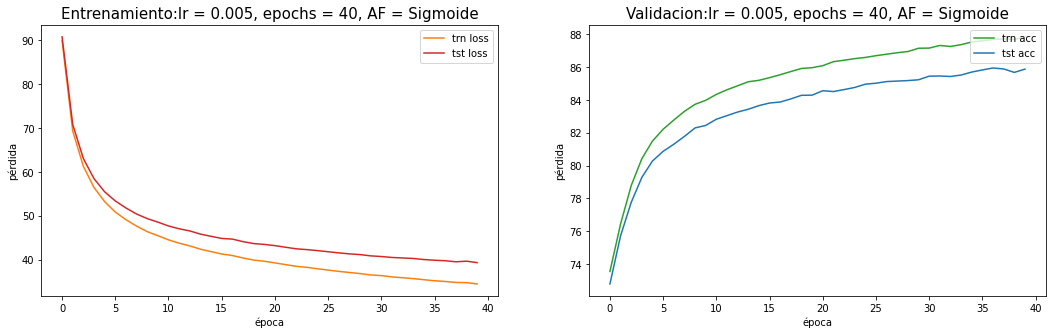

In [69]:
param12 = "lr = 0.005, epochs = 40, AF = Sigmoide"
plot_loss_acc(loss12, acc12,  param12)

In [68]:
# Evaluación final

# evaluamos en entrenamiento
trn_loss12, trn_acc12 = eval_epoch(trn_dl, model12)
# evaluamos en prueba
tst_loss12, tst_acc12 = eval_epoch(tst_dl, model12)
print(f'loss=[{trn_loss12:6.2f},{tst_loss12:6.2f}] '
      f'acc=[{trn_acc12:5.2f},{tst_acc12:5.2f}]')

loss=[ 34.50, 39.38] acc=[87.85,85.87]


Para esta arquitectura vamos a modificar el número de capas y el número de neuronas

In [70]:
# Modificamos el modelo con más capas ocultas

# definición del modelo
class FCN_2(nn.Module):

    # definimos el constructor que recibe los parámetros que vamos a variar
    def __init__(self):
        # inicilización del objeto padre, obligatorio
        super(FCN_2, self).__init__()

        # tamaño de la entrada
        self.I = 1 * 28 * 28
        # tamaño de la salida 
        

        FC1, FC2, FC3 = 128, 256, 10

      #definimos las capas
        self.cls = nn.Sequential(
            # primera capa completamente conectada toma n vectores de 1x28x28 y transformalos a n vectores de 128
            nn.Linear(self.I, FC1),
            #funcion de activacion relu
            nn.ReLU(),
            # segunda capa completamente conectada entrada de 128 y salida de 256
            nn.Linear(FC1, FC2),

            nn.ReLU(),

            # tercera y ultima capa completamente conectada, entrada de 256 y salida de 10

            nn.Linear(FC2, FC3)
        )
            
    #inferencia
    def forward(self, x):
        # [1,28,28]  => (1*28*28)
        x = x.view(-1, self.I)
        #inferencia
        x = self.cls(x)
        return x    

In [72]:
# Veamos si aumentando las capas ocultas y las neuronas nos da un mejor rendimiento la red, vamos a entrenar menos epocas con la misma tasa de aprendizaje

model2 = FCN_2()
loss2, acc2 = train(model2, trn_dl, tst_dl, 0.005, 20)

  0%|          | 0/20 [00:00<?, ?it/s]

E00 loss=[ 54.27, 56.72] acc=[80.59,79.32]
E01 loss=[ 46.59, 49.73] acc=[83.49,82.17]
E02 loss=[ 41.90, 45.63] acc=[84.96,83.39]
E03 loss=[ 39.75, 43.63] acc=[85.92,84.36]
E04 loss=[ 38.46, 42.76] acc=[86.10,84.40]
E05 loss=[ 36.56, 41.28] acc=[86.84,85.14]
E06 loss=[ 34.94, 39.87] acc=[87.45,85.91]
E07 loss=[ 34.31, 39.57] acc=[87.64,85.91]
E08 loss=[ 34.36, 39.82] acc=[87.60,85.77]
E09 loss=[ 32.07, 37.77] acc=[88.41,86.31]
E10 loss=[ 31.65, 37.37] acc=[88.78,86.65]
E11 loss=[ 30.37, 36.51] acc=[89.24,86.87]
E12 loss=[ 30.16, 36.33] acc=[89.20,87.02]
E13 loss=[ 29.26, 35.83] acc=[89.50,87.35]
E14 loss=[ 29.12, 35.84] acc=[89.52,87.25]
E15 loss=[ 28.34, 35.52] acc=[89.86,87.15]
E16 loss=[ 27.63, 35.01] acc=[89.94,87.23]
E17 loss=[ 28.32, 35.92] acc=[89.72,87.19]
E18 loss=[ 27.16, 35.12] acc=[90.14,87.31]
E19 loss=[ 26.55, 34.80] acc=[90.56,87.66]


In [80]:
print(model2)

FCN_2(
  (cls): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)


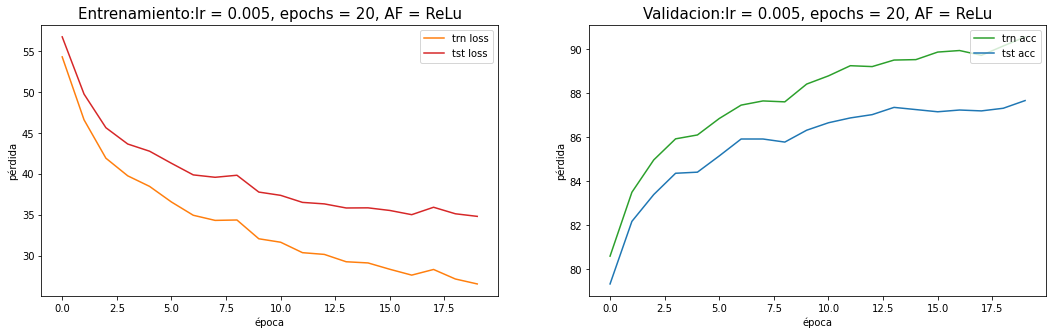

In [73]:
param2 = "lr = 0.005, epochs = 20, AF = ReLu"
plot_loss_acc(loss2, acc2,  param2)

In [77]:
# Evaluación final

# evaluamos en entrenamiento
trn_loss2, trn_acc2 = eval_epoch(trn_dl, model2)
# evaluamos en prueba
tst_loss2, tst_acc2 = eval_epoch(tst_dl, model2)
print(f'loss=[{trn_loss2:6.2f},{tst_loss2:6.2f}] '
      f'acc=[{trn_acc2:5.2f},{tst_acc2:5.2f}]')

loss=[ 26.55, 34.87] acc=[90.56,87.65]


In [74]:
# Modificamos el modelo con más capas ocultas

# definición del modelo
class FCN_3(nn.Module):

    # definimos el constructor que recibe los parámetros que vamos a variar
    def __init__(self):
        # inicilización del objeto padre, obligatorio
        super(FCN_3, self).__init__()

        # tamaño de la entrada
        self.I = 1 * 28 * 28
        # tamaño de la salida 
        

        FC1, FC2, FC3, FC4 = 128, 256, 512, 10

      #definimos las capas
        self.cls = nn.Sequential(
            # primera capa completamente conectada toma n vectores de 1x28x28 y transformalos a n vectores de 128
            nn.Linear(self.I, FC1),
            #funcion de activacion relu
            nn.ReLU(),
            # segunda capa completamente conectada entrada de 128 y salida de 256
            nn.Linear(FC1, FC2),
            nn.ReLU(),
            # tercera capa completamente conectada, entrada de 256 y salida de 512
            nn.Linear(FC2, FC3),

            nn.ReLU(),
            # Ultima capa completamente conectada, entrada de 512 y salida de 10 clases 
            nn.Linear(FC3, FC4)
        )
            
    #inferencia
    def forward(self, x):
        # [1,28,28]  => (1*28*28)
        x = x.view(-1, self.I)
        #inferencia
        x = self.cls(x)
        return x    

In [75]:
# Veamos si aumentando las capas ocultas y las neuronas nos da un mejor rendimiento la red, vamos a entrenar menos epocas con la misma tasa de aprendizaje

model3 = FCN_3()
loss3, acc3 = train(model3, trn_dl, tst_dl, 0.01, 20)

  0%|          | 0/20 [00:00<?, ?it/s]

E00 loss=[ 48.80, 52.09] acc=[82.47,81.25]
E01 loss=[ 41.26, 45.40] acc=[85.02,83.51]
E02 loss=[ 38.16, 42.45] acc=[85.99,84.58]
E03 loss=[ 33.78, 38.88] acc=[87.90,86.18]
E04 loss=[ 31.92, 37.55] acc=[88.51,86.61]
E05 loss=[ 31.12, 37.36] acc=[88.65,86.64]
E06 loss=[ 29.32, 36.11] acc=[89.27,86.83]
E07 loss=[ 28.65, 35.82] acc=[89.59,86.80]
E08 loss=[ 27.69, 35.42] acc=[89.92,87.09]
E09 loss=[ 26.02, 34.23] acc=[90.52,87.60]
E10 loss=[ 25.54, 34.16] acc=[90.67,87.66]
E11 loss=[ 24.55, 33.74] acc=[91.03,87.84]
E12 loss=[ 24.51, 34.33] acc=[91.05,87.63]
E13 loss=[ 23.71, 34.43] acc=[91.44,87.80]
E14 loss=[ 22.17, 32.82] acc=[91.98,88.23]
E15 loss=[ 21.55, 33.34] acc=[92.10,88.16]
E16 loss=[ 21.10, 33.30] acc=[92.33,88.21]
E17 loss=[ 20.44, 33.32] acc=[92.52,88.47]
E18 loss=[ 19.52, 33.21] acc=[92.89,88.42]
E19 loss=[ 19.42, 33.53] acc=[92.92,88.52]


In [82]:
print(model3)

FCN_3(
  (cls): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
)


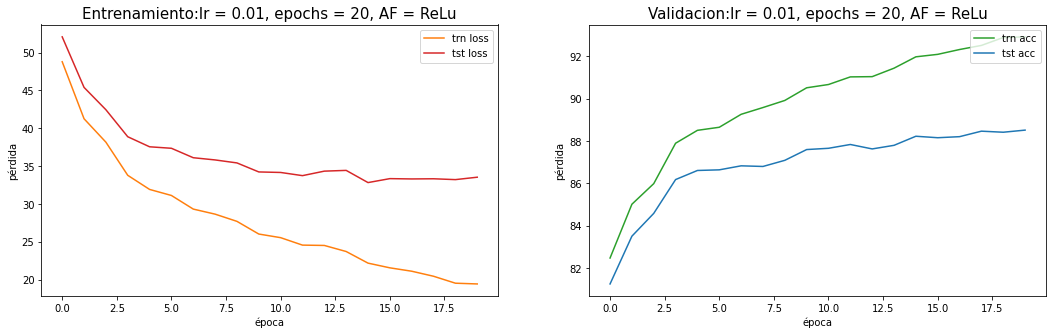

In [76]:
param3 = "lr = 0.01, epochs = 20, AF = ReLu"
plot_loss_acc(loss3, acc3,  param3)

In [81]:
# Evaluación final

# evaluamos en entrenamiento
trn_loss3, trn_acc3 = eval_epoch(trn_dl, model3)
# evaluamos en prueba
tst_loss3, tst_acc3 = eval_epoch(tst_dl, model3)
print(f'loss=[{trn_loss3:6.2f},{tst_loss3:6.2f}] '
      f'acc=[{trn_acc3:5.2f},{tst_acc3:5.2f}]')

loss=[ 19.42, 33.39] acc=[92.92,88.54]


In [78]:
# Evaluación final

# evaluamos en entrenamiento
trn_loss3, trn_acc3 = eval_epoch(trn_dl, model3)
# evaluamos en prueba
tst_loss3, tst_acc3 = eval_epoch(tst_dl, model3)
print(f'loss=[{trn_loss3:6.2f},{tst_loss3:6.2f}] '
      f'acc=[{trn_acc3:5.2f},{tst_acc3:5.2f}]')

loss=[ 19.42, 33.35] acc=[92.92,88.56]


##  Discusión, resultados y conclusiones
* $\textbf{Primer modelo}$:

(0): Linear(in_features=784, out_features=128, bias=True)

(1): ReLU()

(2): Linear(in_features=128, out_features=10, bias=True)
   
 - Epocas: 40
 - Learning rate: 0.001
 - Función de activación: ReLU

 $\textbf{Accuracy test: 87.94 }$


 * $\textbf{Segundo modelo}$:

(0): Linear(in_features=784, out_features=128, bias=True)

(1): Sigmoid()

(2): Linear(in_features=128, out_features=10, bias=True)
   
 - Epocas: 40
 - Learning rate: 0.001
 - Función de activación: Sigmoide

 $\textbf{Accuracy test: 85.87 }$


  * $\textbf{Tercer modelo}$:

(0): Linear(in_features=784, out_features=128, bias=True)

(1): ReLU()

(2): Linear(in_features=128, out_features=256, bias=True)

(3): ReLU()

(4): Linear(in_features=256, out_features=10, bias=True)
   
 - Epocas: 20
 - Learning rate: 0.001
 - Función de activación: ReLu

 $\textbf{Accuracy test: 87.65 }$

  * $\textbf{Cuarto modelo}$:

(0): Linear(in_features=784, out_features=128, bias=True)

(1): ReLU()

(2): Linear(in_features=128, out_features=256, bias=True)

(3): ReLU()

(4): Linear(in_features=256, out_features=512, bias=True)

(5): ReLU()

(6): Linear(in_features=512, out_features=10, bias=True)


   
 - Epocas: 20
 - Learning rate: 0.01
 - Función de activación: ReLu

 $\textbf{Accuracy test: 88.56}$



 



 
  


* Se puede observar que uno de los factores que beneficia el desempeño de la red es la tasa de aprendizaje. La arquitectura que ocupo una tasa de aprendizaje de 0.01 tiene un desempeño destacable de 88.56 en validación comparándola con las arquitecturas donde se utilizo 0.001, sin embargo, en la graficas de aprendizaje podemos observar que esta convergiendo a un valor, como si no fuera a aumentar, esto puede ser que debido a una tasa de aprendizaje más alta el algoritmo del descenso del gradiente puede saltarse el punto mínimo.

* Otro de los parámetros que me pareció muy importante, el cual ya se ha discutido en la clase es el número de épocas con las que se entrena el modelo. Podemos observar que en el primer modelo donde unicamente se ocupo una capa oculta pero se entreno durante 40 épocas tuvo un accuracy de 87.94 siendo el segundo mejor de los que se entrenaron.

* La variación del número de capas ocultas en la red y el numero de neuronas en cada una de ellas parece mejorar el modelo, requiriendo un mejor número de épocas para poder obtener un buen desempeño. 

* Por ultimo, se realizo una comparación entre el uso de la función de activación ReLu y sigmoide, cuando se utiliza la función ReLu el modelo aprende de forma más rápida, en cuanto a la función sigmoide podemos observar en el historial de aprendizaje que aprende de forma más lenta y se va estancando en ciertos valores, esto se puede deber a lo discutido en clase sobre que la derivada de la función sigmoide es saturada y favorece el desvanecimiento del gradiente.


